# ECON570 Assignment2
* Instructor: Ida Johnsson
* Author: Seongmoon Cho
* Date: 04/15/2022

## Simulate Data Generating Processes
* Illustrate your DGP with a DAG
* Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is in cases a and b.
* Give an example of a real-life situation that might be consistent with the DGP.

In [1]:
import pandas as pd
import numpy as np
import graphviz as gr
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(10)

## File directory

In [2]:
folder = "../data/ass2/"

## Define functions

In [3]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
    # Note this is equivalent to np.var(Yt,ddof)

def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)
    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))
    
    return Y

def fn_randomize_treatment(N,p=0.5):
    """
    A fuction that assigns treatment to N samples with the probability of p
    N - sample size
    p - probability of assignment
    """
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [4]:
def fn_generate_data(tau, N, p, p0, corr, flagX = False):
    """
    p - number of covariates generated
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
  
    allX = fn_generate_multnorm(N,corr,nvar)
    Xs = allX[:,0].reshape([N,1]) # selection bias variable
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    Yab = tau*T+X@beta0+err # outcome equation
    
    if flagX==False:   # No X's included
        return (Yab,T)
    
    elif flagX==1:     # use the right covariates in regression
        return (Yab,T,X)
    
    elif flagX==2:     # use some of the right covariates and fail to control for a confounder
        T = np.array([(1 if C[i]>=0 else 0) for i in range(N)]).reshape([N,1]) # confounding, treatment is related to the covariate
        Yab = tau*T+X@beta0+0.6*C+err # outcome equation
        return (Yab,T,X,C)
    
    elif flagX==3:     # use some of the right covariates and control for a confounder
        T = np.array([(1 if C[i]>=0 else 0) for i in range(N)]).reshape([N,1]) # confounding, treatment is related to the covariate
        Yab = tau*T+X@beta0+0.6*C+err # outcome equation
        return (Yab,T,X,C)
    
    elif flagX==4:     # use some of the right covariates and selection bias
        S = np.array([2*(Xs[i]*T[i]) for i in range(N)]).reshape([N,1]) # selection bias, treatment affects both Y and X1
        Yab = tau*T+X@beta0+0.9*S+err # outcome equation
        return (Yab,T,X,S)
    
    elif flagX==5:     # use some of the right covariates and selection bias
        S = np.array([2*(Xs[i]*T[i]) for i in range(N)]).reshape([N,1]) # selection bias, treatment affects both Y and X1
        Yab = tau*T+X@beta0+0.9*S+err # outcome equation
        return (Yab,T,X,S)

In [5]:
def fn_run_experiments(tau,Nrange,p,p0,corr,flagX=False):
    """
    tau - treatment effect
    Nrange - range of sample sizes
    p - number of covariates generated
    p0 - number of covariates included with nonzero coefficient
    corr - correlation between covariates
    """
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            # No X's included
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and fail to control for a confounder
            Yexp,T,X,C = fn_generate_data(tau,N,p,p0,corr,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==3:
            # use some of the right covariates and control for a confounder
            Yexp,T,X,C = fn_generate_data(tau,N,p,p0,corr,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs,C],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==4:
            # use some of the right covariates and control for selection bias
            Yexp,T,X,S = fn_generate_data(tau,N,p,p0,corr,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs,S],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==5:
            # use some of the right covariates and does not contorl for selection bias
            Yexp,T,X,S = fn_generate_data(tau,N,p,p0,corr,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    # plots x against y
    # the label is what comes out in the legend
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    # axhline is a horizontal line at the true value of tau
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    # fill confidence interval
    # alpha is the opacity
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

In [6]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    cval - confidence value, default 1.96 as 5% significance level
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)


## Q1. 
Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. How does your estimate of the treatment effect parameter compare in the following two cases

    a. You do not control for any covariates
    b. You control for all the covariates that affect the outcome

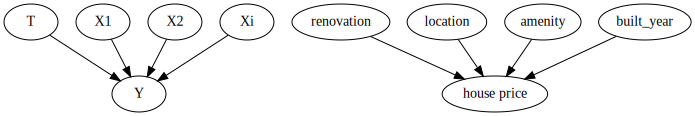

In [7]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X1", "Y")
g.edge("X2", "Y")
g.edge("Xi", "Y")


g.edge("renovation", "house price")
g.edge("location", "house price")
g.edge("amenity", "house price")
g.edge("built_year", "house price")

g

When a house is renovated, the price is expected to increase. However, house price is also explained by other various factors such as location, amenity, and built year. Like the DGP, we can regard renovation as a treatment and other factors as covariates. 

### a. You do not control for any covariates

$y_i = \tau*T_i+e_i$

In [8]:
tau = 0.2
Nrange = range(10,1000,2) # loop over N values
p = 10
p0 = 0 # number of covariates used in the DGP
corr = .5

(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr)

100%|███████████████████████████████████████████████████████████████████████████████| 495/495 [00:02<00:00, 242.45it/s]


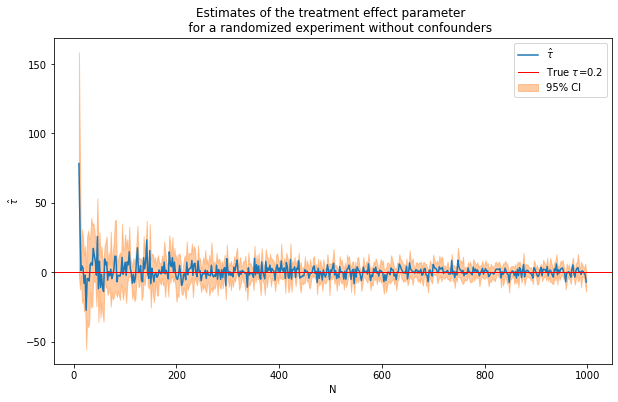

In [9]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

The graph above shows the estimates for the treatment effect parameter for a randomized expriment without confounders depending on sample size. As the size increases, the variances of estimates become small and close to zero. 

#### Run R Monte Carlo iterations and compute bias, RMSE and size

In [10]:
estDict = {}
datDict = {}
R = 500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,p,p0,corr)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    datDict[N] = np.concatenate([Yexp,T],axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 92.37it/s]


In [11]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.22619126256486288, RMSE=7.8714080444137124, size=0.052
N=1000: bias=0.015581185845390396, RMSE=2.570499505825566, size=0.048


The Monte-Carlo simulation shows that bias decreased as the sample size increased from 100 to 1000. Also, RMSE lowered and the size of errors were 0.05.

In [12]:
# save the generated data
q1a_100 = pd.DataFrame.from_dict(datDict[100])
q1a_100.columns = ['Yexp', 'T']
q1a_100.to_csv(folder+"q1a_100.csv", index=False)
q1a_1000 = pd.DataFrame.from_dict(datDict[1000])
q1a_1000.columns = ['Yexp', 'T']
q1a_1000.to_csv(folder+"q1a_1000.csv", index=False)

### b. You control for all the covariates that affect the outcome

$y_i = \tau*T_i+\beta'*x_i+e_i$

In [13]:
tau = 0.2
Nrange = range(10,1000,2) # loop over N values
p = 10
p0 = 8 # number of covariates used in the DGP
corr = .5
flagX=1

(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,flagX)

100%|███████████████████████████████████████████████████████████████████████████████| 495/495 [00:02<00:00, 165.46it/s]


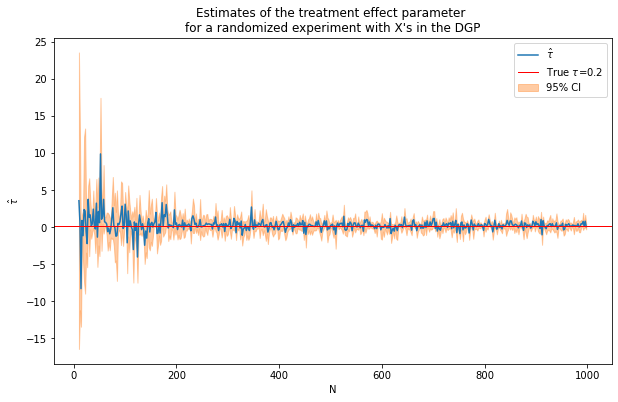

In [14]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

#### Run R Monte Carlo iterations and compute bias, RMSE and size

In [15]:
estDict = {}
datDict = {}
R = 500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    datDict[N] = np.concatenate([Yexp,T,Xobs],axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 83.17it/s]


In [16]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.042363143795902, RMSE=1.1389590740410305, size=0.052
N=1000: bias=0.005391792834599492, RMSE=0.35015508501946746, size=0.054


Compared to the results in (a), bias decreased regardless of sample size since the model control for all covariates. Also, the RMSEs decreased compared to (a).

In [17]:
# save the generated data
q1b_100 = pd.DataFrame.from_dict(datDict[100])
q1b_100.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
q1b_100.to_csv(folder+"q1b_100.csv", index=False)
q1b_1000 = pd.DataFrame.from_dict(datDict[1000])
q1b_1000.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
q1b_1000.to_csv(folder+"q1b_1000.csv", index=False)

## Q2. 
Simulate a DGP with a confounder (common cause)
    
    a. You fail to control for the confounder
    b. You do control for the confounder
   

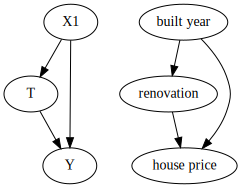

In [19]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X1", "T")
g.edge("X1", "Y")

g.edge("built year", "renovation"),
g.edge("built year", "house price"),
g.edge("renovation", "house price")

g

In fact, a housing unit becomes old-fashioned and deprecated as it aged. The older housing unit is more likely to be renovated and also affects directly its price.

### a. You fail to control for the confounder

In [20]:
# 
tau = 0.2
Nrange = range(50,1000,2) # loop over N values
p = 10
p0 = 8 # number of covariates used in the DGP
corr = .5
flagX=2

(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,flagX)


100%|███████████████████████████████████████████████████████████████████████████████| 475/475 [00:03<00:00, 148.80it/s]


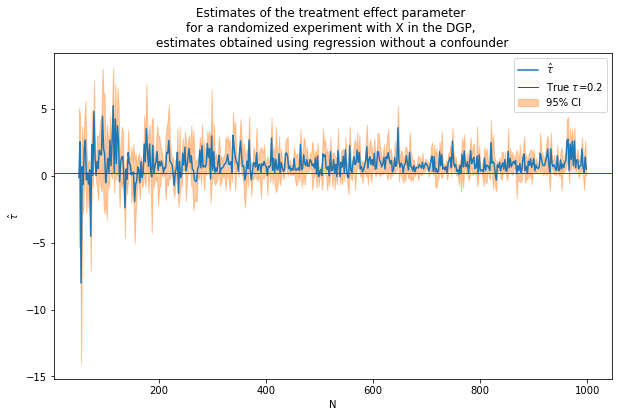

In [21]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X in the DGP, 
estimates obtained using regression without a confounder"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

The graph above shows the fail of estimation as the model does not control for a confounder. The tauhat looks odd from the true tau value of 0.2.

#### Run R Monte Carlo iterations and compute bias, RMSE and size

In [24]:
estDict = {}
datDict = {}
R = 500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X,C = fn_generate_data(tau,N,p,p0,corr,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    datDict[N] = np.concatenate([Yexp,T,Xobs,C],axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 68.25it/s]


In [25]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.6138333197757219, RMSE=1.4086792131249952, size=0.16
N=1000: bias=0.6806706192682525, RMSE=0.847309341003622, size=0.572


Since the model does not control for a covariate, the Monte-Carlo simulation shows the biased results, large RMSE, and large error size(>0.05).

In [26]:
# save the generated data
q2a_100 = pd.DataFrame.from_dict(datDict[100])
q2a_100.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8','C']
q2a_100.to_csv(folder+"q2a_100.csv", index=False)
q2a_1000 = pd.DataFrame.from_dict(datDict[1000])
q2a_1000.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8','C']
q2a_1000.to_csv(folder+"q2a_1000.csv", index=False)

### b. You do control for the confounder

In [27]:
# 
tau = 0.2
Nrange = range(50,1000,2) # loop over N values
p = 10
p0 = 8 # number of covariates used in the DGP
corr = .5
flagX=3

(nvalues2_c,tauhats2_c,sehats2_c,lb2_c,ub2_c) = fn_run_experiments(tau,Nrange,p,p0,corr,flagX)


100%|███████████████████████████████████████████████████████████████████████████████| 475/475 [00:03<00:00, 155.01it/s]


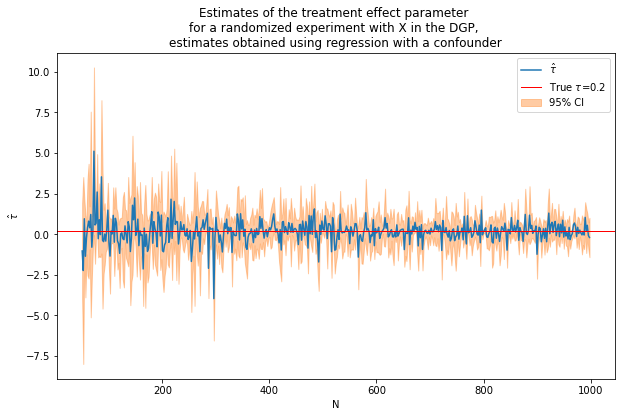

In [28]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X in the DGP, 
estimates obtained using regression with a confounder"""
fn_plot_with_ci(nvalues2_c,tauhats2_c,tau,lb2_c,ub2_c,caption)

Compared to (a), the graph looks closre to the true value of 0.2, as the model includes the confounder.

#### Run R Monte Carlo iterations and compute bias, RMSE and size

In [29]:
estDict = {}
datDict = {}
R = 500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X,C = fn_generate_data(tau,N,p,p0,corr,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs,C],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat] 
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    datDict[N] = np.concatenate([Yexp,T,Xobs,C],axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.98it/s]


In [30]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.007870470569054532, RMSE=1.4861575770466067, size=0.052
N=1000: bias=-0.015362975207430242, RMSE=0.4114321446894327, size=0.038


The biase becomes much smaller. The RMSEs are smaller. And, the error size for each sample size simulation is smaller or at about 0.05.

In [31]:
# save the generated data
q2b_100 = pd.DataFrame.from_dict(datDict[100])
q2b_100.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'C']
q2b_100.to_csv(folder+"q2b_100.csv", index=False)
q2b_1000 = pd.DataFrame.from_dict(datDict[1000])
q2b_1000.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'C']
q2b_1000.to_csv(folder+"q2b_1000.csv", index=False)

#### Q3. 
Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

    a. You control for the variable in between the path from cause to effect
    b. You do not control for the variable in between the path from cause to effect

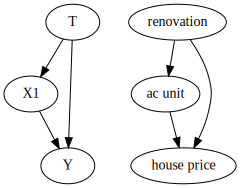

In [32]:
g = gr.Digraph()
g.edge("T", "X1")
g.edge("T", "Y")
g.edge("X1", "Y")

g.edge("renovation", "ac unit")
g.edge("renovation", "house price")
g.edge("ac unit", "house price")

g

An air conditioning unit(AC unit)  was not buit in old housing units. When a housing unit is renovated, AC units are added in a hot weather area that increases house price additionally compared to a housing unit without AC units.  

### a. You control for the variable in between the path from cause to effect

In [33]:
# 
tau = 0.2
Nrange = range(50,1000,2) # loop over N values
p = 10
p0 = 8 # number of covariates used in the DGP
corr = .5
flagX=4

(nvalues3,tauhats3,sehats3,lb3,ub3) = fn_run_experiments(tau,Nrange,p,p0,corr,flagX)


100%|███████████████████████████████████████████████████████████████████████████████| 475/475 [00:03<00:00, 121.71it/s]


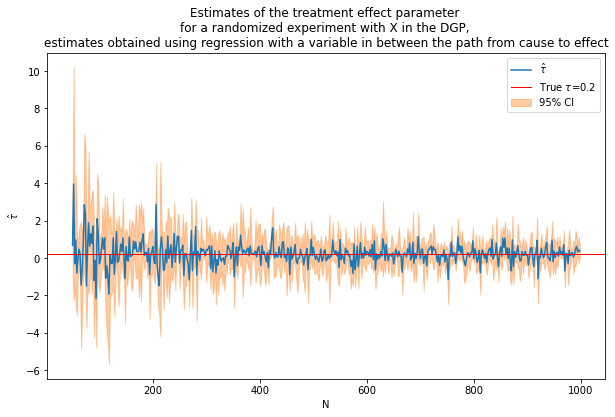

In [34]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X in the DGP, 
estimates obtained using regression with a variable in between the path from cause to effect"""
fn_plot_with_ci(nvalues3,tauhats3,tau,lb3,ub3,caption)

#### Run R Monte Carlo iterations and compute bias, RMSE and size

In [35]:
estDict = {}
datDict = {}
R = 500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X,S = fn_generate_data(tau,N,p,p0,corr,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs,S],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    datDict[N] = np.concatenate([Yexp,T,Xobs,S],axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 60.01it/s]


In [36]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.09935300237992734, RMSE=1.1265912618317477, size=0.066
N=1000: bias=0.00851337524421942, RMSE=0.3286494369908827, size=0.042


In [37]:
# save the generated data
q3a_100 = pd.DataFrame.from_dict(datDict[100])
q3a_100.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'S']
q3a_100.to_csv(folder+"q3a_100.csv", index=False)
q3a_1000 = pd.DataFrame.from_dict(datDict[1000])
q3a_1000.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'S']
q3a_1000.to_csv(folder+"q3a_1000.csv", index=False)

### b. You do not control for the variable in between the path from cause to effect

In [38]:
# 
tau = 0.2
Nrange = range(50,1000,2) # loop over N values
p = 10
p0 = 8 # number of covariates used in the DGP
corr = .5
flagX=5

(nvalues3_c,tauhats3_c,sehats3_c,lb3_c,ub3_c) = fn_run_experiments(tau,Nrange,p,p0,corr,flagX)


100%|███████████████████████████████████████████████████████████████████████████████| 475/475 [00:03<00:00, 124.39it/s]


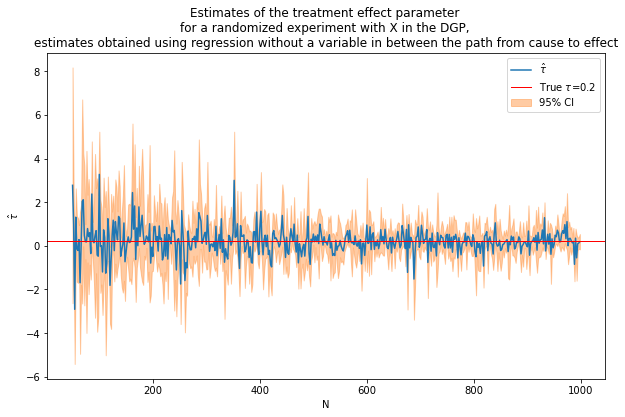

In [39]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X in the DGP, 
estimates obtained using regression without a variable in between the path from cause to effect"""
fn_plot_with_ci(nvalues3_c,tauhats3_c,tau,lb3_c,ub3_c,caption)

#### Run R Monte Carlo iterations and compute bias, RMSE and size

In [40]:
estDict = {}
datDict = {}
R = 500
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X,S = fn_generate_data(tau,N,p,p0,corr,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
    datDict[N] = np.concatenate([Yexp,T,Xobs,S],axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 59.01it/s]


In [41]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.034808878414289056, RMSE=1.2208262675300294, size=0.066
N=1000: bias=-0.010834827126520641, RMSE=0.3737223873734785, size=0.05


The RMSEs from (b) are larger than the results from (a). While the bias and error size do not change much, the variance becomes slightly large.

In [42]:
# save the generated data
q3b_100 = pd.DataFrame.from_dict(datDict[100])
q3b_100.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'S']
q3b_100.to_csv(folder+"q3b_100.csv", index=False)
q3b_1000 = pd.DataFrame.from_dict(datDict[1000])
q3b_1000.columns = ['Yexp', 'T', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'S']
q3b_1000.to_csv(folder+"q3b_1000.csv", index=False)